In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core yandexcloud tavily-python langsmith openai vllm accelerate langchain_community langgraph_sdk wikipedia

In [ ]:
import os
from google.colab import userdata

import operator

import uuid

import builtins

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables.config import RunnableConfig
from langgraph.constants import Send

from IPython.display import Image, display

from tavily import TavilyClient
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

from jinja2 import Template
from pydantic import BaseModel, Field
from typing import Annotated, Any, Optional, List, Literal
from typing_extensions import TypedDict

/tmp/ipython-input-1611001186.py:19: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [ ]:
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_2')
os.environ['TAVILY_API_KEY'] = userdata.get('tavili_hack')


In [ ]:
model_name = "gpt-4o-mini"

tavily_client = TavilyClient(api_key=os.getenv('TAVILY_API_KEY'))

In [ ]:
def display_graph(app, xray=0):
  display(Image(app.get_graph(xray=xray).draw_mermaid_png()))

In [ ]:
@tool
def web_search(query: str) -> str:
    """Performs an internet search and returns the result."""
    return tavily_client.qna_search(query=query)

class FinalAnswer(BaseModel):
  answer: str = Field(description="final answer to user's question.")
  # next_node: = Literal["node_1", "node_2", "node_3"]

In [ ]:
# tools = [web_search, FinalAnswer]
tools = [web_search]
tool_node = ToolNode(tools)

In [ ]:
def generate_tool_description(tool):
    """
    Генерирует краткое и информативное описание инструмента для использования в промпте LLM-агента.
    """
    # Извлекаем основные параметры
    name = tool.name
    description = tool.description.strip() if tool.description else "No description available."

    # Форматируем аргументы в удобный вид
    args = ", ".join([f"{arg}: {details['type']}" for arg, details in tool.args.items()])

    # Формируем финальную строку
    tool_description = f"{name}({args}) - {description}"

    return tool_description

In [ ]:
generate_tool_description(web_search)

'web_search(query: string) - Performs an internet search and returns the result.'

In [ ]:
def clarification_node(state):
  messages = state['messages']
  if len(messages) ==  1:
    response = model.invoke([CLARIFY_SYSTEM_PROMPT] + messages)
  else:
    user_input = builtins.input("")

    messages.append(HumanMessage(content=user_input))

    response = model.invoke([CLARIFY_SYSTEM_PROMPT] + messages)

  return {"messages": [response]}


def route(state) -> Literal['clarify', 'continue']:
  if state['messages'][-1].content == '<END>':
    return 'continue'
  return 'clarify'


def agent_node(state):
  messages = state['messages']

  response = model.invoke([AGENT_SYSTEM_PROMPT] + messages)

  return {"messages": [response]}

In [ ]:
CLARIFY_SYSTEM_PROMPT = """
You are a clarification module in an LLM-based assistant. Your task is to determine if the user's query requires additional clarification before processing. If clarification is needed, ask a concise and relevant follow-up question. If no further clarification is required, output the token <END>. Your goal is to ensure the assistant has all necessary information to provide an accurate response.

### When is clarification needed?
A user's query requires clarification if its answer depends on variable factors such as:
- The user's location (e.g., weather, nearby places, local time).
- The user's preferences or specific details (e.g., booking a flight, choosing a product).
- The user's current context or state (e.g., converting currencies without a date, checking a personalized setting).

If the answer does **not** depend on the user's state, location, or context (e.g., historical facts, general knowledge, company information), output `<END>` immediately.

### Guidelines:
- Ask only **one** clarifying question at a time.
- Keep your question **short and specific**.
- If all needed clarifications have been made, return `<END>`.
- If no clarification is required from the start, return `<END>` immediately.
- **Do not assume missing details**—ask explicitly.

## Examples:
<examples>

### Example 1:
User: "What’s the weather like now?"
Output: "Which city are you in?"
User: "I live in London."
Output: "<END>"

### Example 2:
User: "What is the best restaurant near me?"
Output: "What city or location are you referring to?"
User: "I am in the center of Paris."
Output: "<END>"

### Example 3:
User: "Convert 10 USD to EUR."
Output: "<END>"

### Example 4:
User: "Book a flight."
Output: "What is your departure city?"
User: "New York."
Output: "What is your destination?"
User: "Los Angeles."
Output: "What date do you want to fly?"
User: "Next Friday."
Output: "<END>"

</examples>
"""

In [ ]:
AGENT_SYSTEM_PROMPT = """
You are an AI assistant responsible for answering user queries based on the full conversation history. This history may include clarification questions and user responses, which must be considered to provide an accurate and complete answer.

### Key Instructions:
- Never ask any follow-up questions after choosing a tool.
- **Use full context:** Always base your response on the entire conversation, incorporating any clarifications the user has provided.
- **Use available tools when necessary:** If the query requires up-to-date information, **do not rely on static knowledge**; instead, use the appropriate tool when needed.
"""

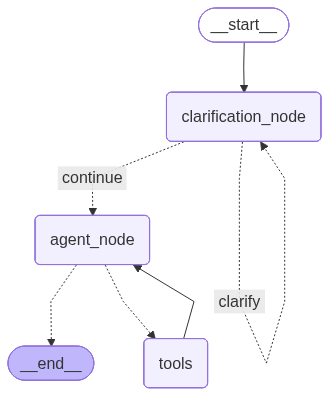

In [ ]:
model = ChatOpenAI(model_name=model_name, temperature=0).bind_tools(tools=tools, tool_choice="auto") # tool_choice="required"

workflow = StateGraph(state_schema=MessagesState)

workflow.add_node("clarification_node", clarification_node)
workflow.add_node("agent_node", agent_node)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "clarification_node")
workflow.add_conditional_edges(
    "clarification_node",
    lambda state: route(state),
    {
      "clarify": "clarification_node",
      "continue": "agent_node"
    }
)

workflow.add_conditional_edges(
    "agent_node",     
    tools_condition,  
)
workflow.add_edge("tools", "agent_node")

app = workflow.compile()

display_graph(app)

In [ ]:
messages = [
    HumanMessage(content="Какая погода у меня?")
]

my_input = {"messages": messages}

events_list = []

for event in app.stream(my_input, stream_mode='updates'): # config,
  key = list(event.keys())[0]
  event[key]['messages'][0].pretty_print()
  events_list.append(event[key]['messages'][0])

# Реализация под опенроутер
т.к. у гпт закончился лимит по токенам..(

In [ ]:
from langchain_openai import ChatOpenAI

OPENROUTER_KEY = userdata.get('OPEN_Router')

model = ChatOpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_KEY,
    model="qwen/qwen3-4b:free",
    temperature=0
).bind_tools(tools=tools, tool_choice="auto")


In [ ]:
def clarification_node(state):
  messages = state['messages']
  if len(messages) ==  1:
    response = model.invoke([CLARIFY_SYSTEM_PROMPT] + messages)
  else:
    user_input = builtins.input("")

    messages.append(HumanMessage(content=user_input))

    response = model.invoke([CLARIFY_SYSTEM_PROMPT] + messages)

  return {"messages": [response]}


def route(state) -> Literal['clarify', 'continue']:
  if state['messages'][-1].content == '<END>':
    return 'continue'
  return 'clarify'


def agent_node(state):
  messages = state['messages']

  response = model.invoke([AGENT_SYSTEM_PROMPT] + messages)

  return {"messages": [response]}

In [ ]:
workflow = StateGraph(state_schema=MessagesState)

workflow.add_node("clarification_node", clarification_node)
workflow.add_node("agent_node", agent_node)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "clarification_node")
workflow.add_conditional_edges(
    "clarification_node",
    lambda state: route(state),
    {
      "clarify": "clarification_node",
      "continue": "agent_node"
    }
)

workflow.add_conditional_edges(
    "agent_node",     
    tools_condition,  )

workflow.add_edge("tools", "agent_node")

app = workflow.compile()

# display_graph(app)

In [ ]:
messages = [
    HumanMessage(content="Какая погода у меня?")
]

my_input = {"messages": messages}

events_list = []

for event in app.stream(my_input, stream_mode='updates'): # config,
  key = list(event.keys())[0]
  event[key]['messages'][0].pretty_print()
  events_list.append(event[key]['messages'][0])

================================== Ai Message ==================================

Какой город или регион вы хотите узнать погоду?
Москва
================================== Ai Message ==================================

<END>
================================== Ai Message ==================================
Tool Calls:
  web_search (chatcmpl-tool-3a4a032b929041b28deb4787dc01c66f)
 Call ID: chatcmpl-tool-3a4a032b929041b28deb4787dc01c66f
  Args:
    query: current weather in Moscow
================================= Tool Message =================================
Name: web_search

As of September 11, 2025, Moscow is sunny with a temperature of 68°F. Winds are light from the northwest. The forecast predicts mild weather for the next few days.
================================== Ai Message ==================================

В Москве 11 сентября 2025 года: ясно, температура 68°F (20°C), слабый ветер с северо-запада. Ожидается умеренная погода в ближайшие дни.


# Трассировка под формат json

In [ ]:
import time
import uuid
import json

class Tracer:
    def __init__(self, session_id="notebook_session"):
        self.session_id = session_id
        self.events = []

    def log_event(self, event_type, agent_name, agent_type, data=None, parent_event_id=None, duration=None, success=True):
        event_id = str(uuid.uuid4())
        timestamp = time.time()

        event = {
            "event_id": event_id,
            "timestamp": timestamp,
            "event_type": event_type,
            "agent_name": agent_name,
            "agent_type": agent_type,
            "data": data or {},
            "parent_event_id": parent_event_id,
            "session_id": self.session_id,
            "duration": duration,
            "success": success,
        }

        self.events.append(event)
        return event_id  


In [ ]:
def clarification_node(state, tracer: Tracer, parent_event_id=None):
    start_id = tracer.log_event(
        event_type="agent_start",
        agent_name="clarification_node",
        agent_type="clarification",
        data={"step": len(state["messages"])},
        parent_event_id=parent_event_id
    )
    t0 = time.time()

    messages = state['messages']
    if len(messages) == 1:
        response = model.invoke([CLARIFY_SYSTEM_PROMPT] + messages)
    else:
        user_input = builtins.input("")
        messages.append(HumanMessage(content=user_input))
        response = model.invoke([CLARIFY_SYSTEM_PROMPT] + messages)

    tracer.log_event(
        event_type="message_sent",
        agent_name="clarification_node",
        agent_type="clarification",
        data={"message": response.content},
        parent_event_id=start_id
    )

    tracer.log_event(
        event_type="agent_end",
        agent_name="clarification_node",
        agent_type="clarification",
        data={"success": True},
        parent_event_id=start_id,
        duration=time.time() - t0
    )

    return {"messages": [response]}


In [ ]:
tracer = Tracer(session_id="notebook_session")

messages = [HumanMessage(content="Какая сейчас у меня погода?")]
my_input = {"messages": messages}

for event in app.stream(my_input, stream_mode="updates"):
    key = list(event.keys())[0]
    msg = event[key]['messages'][0]
    msg.pretty_print()

    tracer.log_event(
        event_type="message_sent",
        agent_name="line_agents",
        agent_type="custom",
        data={"message": msg.content}
    )


================================== Ai Message ==================================

Какой город или регион вы сейчас посетите?
Москва
================================== Ai Message ==================================
Tool Calls:
  web_search (chatcmpl-tool-5f784821a132414087e2e6cab45994d3)
 Call ID: chatcmpl-tool-5f784821a132414087e2e6cab45994d3
  Args:
    query: current weather in Moscow

================================== Ai Message ==================================

Сейчас в Москве погода: облака, температура воздуха +22°C, дождь возможен. 🌫️

================================== Ai Message ==================================

Сейчас в Москве: облака, температура воздуха +22°C, дождь возможен. 🌫️
хорошо, хватит я понял
================================== Ai Message ==================================

<END>
================================== Ai Message ==================================

Спасибо, что разобрался! Если будете нужны дополнительные сведения — не стесняйтесь спрашивать. 😊


In [ ]:
output_file = "session_trace.json"

session_json = {
    "session_id": tracer.session_id,
    "events": tracer.events
}

with open(output_file, "w", encoding="utf-8") as f:
    json.dump(session_json, f, ensure_ascii=False, indent=2)

print(f"Логи успешно сохранены в {output_file}")

Логи успешно сохранены в session_trace.json
